# Анализ

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
import imblearn
import transformers as ppb
import torch

# Предобработка
from pymystem3 import Mystem
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModel
from tqdm import notebook
import torch
# Обучение
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
# Тест
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, accuracy_score, recall_score


# Remove warnings
import warnings
warnings.filterwarnings('ignore')


In [70]:
file_path = 'chd_addmit_300.xlsx'
data = pd.read_excel(file_path)

# отбор признаков
data = data[['target', 'Операция (основная / первая в ИБ)']]

# Предобработка.

In [71]:
# Делаем заглушки
for col in data.columns.tolist():
  if data[col].dtypes == 'object':
    data[col] = data[col].fillna('Нет данных')

In [72]:
# Функция для очистки текста от лишних символов
def clean_text(text):
    # приводим текст к нижнему регистру
    text = text.lower()
    # создаем регулярное выражение для удаления лишних символов
    regular = r'[\*+\#+\№\"\-+\+\=+\?+\&\^\.+\;\,+\>+\(\)\/+\:\\+]'
    # регулярное выражение для замены ссылки на "URL"
    regular_url = r'(http\S+)|(www\S+)|([\w\d]+www\S+)|([\w\d]+http\S+)'
    # удаляем лишние символы
    text = re.sub(regular, '', text)
    # заменяем ссылки на "URL"
    text = re.sub(regular_url, r'URL', text)
    # заменяем числа и цифры на ' NUM '
    text = re.sub(r'(\d+\s\d+)|(\d+)',' NUM ', text)
    # удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    # возвращаем очищенные данные
    return text

In [73]:
# инициализируем токенизатор
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
# экземпляр модели
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [74]:
%%time
# список эмбедингов разных признаков
embeddings_list = []

for col in ['Операция (основная / первая в ИБ)']:
  # создаем список для хранения очищенных данных
  cleaned_text = []
  # для каждого сообщения text из столбца data[col]
  for text in data[col]:
      # очищаем данные  
      text = clean_text(text)
      # добавляем очищенные данные в список cleaned_text
      cleaned_text.append(text)
  # записываем очищенные данные в новую колонку
  data[col] = cleaned_text
  # токенизируем текст
  data[col] = data[col].apply(lambda x: tokenizer.encode(x,
                                                         add_special_tokens=True,
                                                         truncation=True,
                                                         max_length=512))  
  # токенизированный текст
  tokenized = data[col]

  # применим padding к векторам
  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)
  # англ. вектор с отступами
  padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

  # создадим маску для важных токенов
  attention_mask = np.where(padded != 0, 1, 0)
  print('attention_mask:',attention_mask.shape)

  batch_size = 10

  # создаем эмбеддинги
  embeddings = []
  for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
          batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
          attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
          
          with torch.no_grad():
              batch_embeddings = model(batch, attention_mask=attention_mask_batch)
          
          embeddings.append(batch_embeddings[0][:,0,:].numpy())
  # добавляем эмбединги признака в список
  embeddings_list.append(embeddings)

print('embeddings_list:',len(embeddings_list))

attention_mask: (300, 402)


  0%|          | 0/30 [00:00<?, ?it/s]

embeddings_list: 1
Wall time: 2min 12s


Algorithm: XGBoost, Score: 0.8904946474713917, Std: 0.0718776534662266


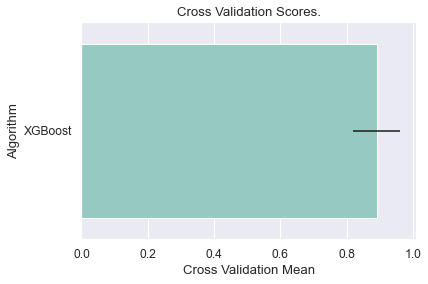

Wall time: 2.4 s


In [75]:
%%time
# проверим модель на эффективность
for i in range(len(embeddings_list)):
  features = np.concatenate(embeddings_list[i])
  X_train, X_test, y_train, y_test = train_test_split(features, data['target'], test_size=0.25, random_state=5)

  classifiers = []
  classifiers.append(XGBClassifier(gamma=0, max_depth=3, min_child_weight=1, n_estimators=50))


  cv_results = []
  for classifier in classifiers:
      cv_results.append(cross_val_score(classifier, X_train, y_train, scoring = 'roc_auc', cv = 5))

  cv_mean = []
  cv_std = []
  for cv_result in cv_results:
      cv_mean.append(cv_result.mean())
      cv_std.append(cv_result.std())
      
  cv_res = pd.DataFrame({'Cross Validation Mean': cv_mean, 
                        'Cross Validation Std': cv_std, 
                        'Algorithm': ['XGBoost']})
  cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)

  sns.barplot(x='Cross Validation Mean', y='Algorithm', 
              data = cv_res, order = cv_res.sort_values(by = 'Cross Validation Mean', 
                                                        ascending = False)['Algorithm'], 
              palette = 'Set3', **{'xerr': cv_std})
  plt.ylabel('Algorithm')
  plt.title(f'Cross Validation Scores.')

  result = cv_res.sort_values('Cross Validation Mean', ascending=False).reset_index()
  a, sc,st =  result['Algorithm'][0], result['Cross Validation Mean'][0], result['Cross Validation Std'][0]
  print(f'Algorithm: {a}, Score: {sc}, Std: {st}')
  plt.show()

# Модель

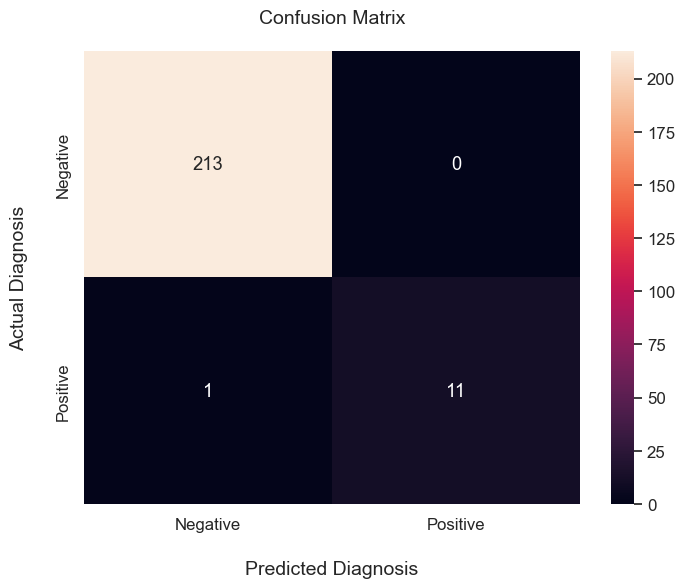

In [76]:
model = XGBClassifier(gamma=0, max_depth=3, min_child_weight=1, n_estimators=50).fit(X_train,y_train)

plt.figure(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(confusion_matrix(y_train, model.predict(X_train)), annot=True, fmt='d', )
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_title("Confusion Matrix", fontsize=14, pad=20)
plt.show()

Модель ошиблась только 1 раз с одной единицей.

# Тест

DummyClassifier: 0.97
accuracy_score: 0.96
AUC-ROC: 0.84


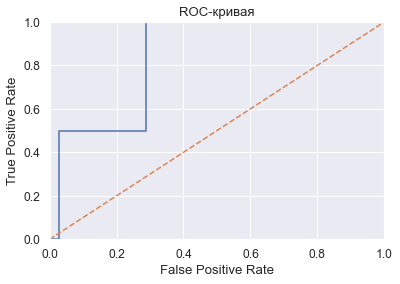

In [80]:
clf = DummyClassifier(strategy='most_frequent', random_state=5)
clf.fit(X_train, y_train)
print("DummyClassifier: %.2f" % clf.score(X_test, y_test))
print('accuracy_score:', accuracy_score(y_test ,[round(value) for value in model.predict(X_test)]))
print("AUC-ROC: %.2f" % roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()